# Module 4 - Algo Trading using Classification


### Query 4.1 
Import the csv file of the stock which contained the Bollinger columns as well.<br>

a) Create a new column 'Call' , whose entries are -

<ul>
    <li>'Buy' if the stock price is below the lower Bollinger band </li>
    <li>'Hold Buy/ Liquidate Short' if the stock price is between the lower and middle Bollinger band </li>
    <li>'Hold Short/ Liquidate Buy' if the stock price is between the middle and upper Bollinger band </li>
    <li>'Short' if the stock price is above the upper Bollinger band </li>
</ul>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

infosys = pd.read_csv('week3.csv')
infosys = infosys[infosys.upper_band.notnull()].reset_index(drop=True)

def value(x):
    if x['Close Price'] < x['lower_band']:
        return 'Buy'
    elif x['Close Price'] < x['middle_band']:
        return 'Hold Buy/Liquidate Short'
    elif x['Close Price'] < x['upper_band']:
        return 'Hold Short/Liquidate Buy'
    else:
        return 'Short'

infosys['Call'] = infosys.apply(lambda x : value(x),axis=1)

b) Now train a classification model with the 3 bollinger columns and the stock price as inputs and 'Call' as output. Check the accuracy on a test set. (There are many classifier models to choose from, try each one out and compare the accuracy for each)

In [2]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = \
    train_test_split(infosys[['Close Price','lower_band','middle_band','upper_band']],\
                     infosys.Call,test_size=0.3,random_state=100)

In [3]:
# K-Nearest Neighbors Classifier

from sklearn.neighbors import KNeighborsClassifier as KNC

k_classifier = KNC()
k_classifier.fit(train_data,train_labels)
print('Accuracy = ',round(k_classifier.score(test_data,test_labels)*100,2),'%')

Accuracy =  83.45 %


In [4]:
# Naive Bayes Classifier

from sklearn.naive_bayes import MultinomialNB as NBC

b_classifier = NBC()
b_classifier.fit(train_data,train_labels)
print('Accuracy =',round(b_classifier.score(test_data,test_labels)*100,2),'%')

Accuracy = 59.31 %


In [5]:
# Logistic Regression Classifier

from sklearn.linear_model import LogisticRegression as LR

l_classifier = LR()
l_classifier.fit(train_data,train_labels)
print('Accuracy =',round(l_classifier.score(test_data,test_labels)*100,2),'%')

Accuracy = 93.1 %


In [6]:
# Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier as DTC
d_classifier = DTC(random_state = 108)
d_classifier.fit(train_data,train_labels)
print('Accuracy =',round(d_classifier.score(test_data,test_labels)*100,2),'%')

Accuracy = 75.17 %


In [7]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier as RFC
r_classifier = RFC(random_state = 0)
r_classifier.fit(train_data,train_labels)
print('Accuracy =',round(r_classifier.score(test_data,test_labels)*100,2),'%')

Accuracy = 82.76 %


c) Import another stock data and create the bollinger columns. Using the already defined model, predict the daily calls for this new stock.

In [8]:
reliance = pd.read_csv('RELIANCE.csv')
reliance = reliance[reliance.Series == 'EQ'].reset_index(drop=True)
rolling_mean = reliance['Average Price'].rolling(14).mean()
standard_deviation = reliance['Average Price'].rolling(14).std()
reliance['lower_band'] = rolling_mean - 2*standard_deviation
reliance['middle_band'] = rolling_mean
reliance['upper_band'] = rolling_mean + 2*standard_deviation
reliance = reliance[reliance.lower_band.notnull()].reset_index(drop=True)

# Using the Logistic Regression Model
reliance['Call'] = l_classifier.predict(reliance[['Close Price','lower_band','middle_band','upper_band']])

### Query 4.2 
Now, we'll again utilize classification to make a trade call, and measure the efficiency of our trading algorithm over the past two years. For this assignment , we will use RandomForest classifier.

<ul><li>Import the stock data file of your choice</li></ul>

In [9]:
godrej = pd.read_csv('GODREJIND.csv')

<ul>
    <li>Define 4 new columns , whose values are: </li>
    <ul type="disc">
        <li>% change between Open and Close price for the day </li>
        <li>% change between Low and High price for the day </li>
        <li>5 day rolling mean of the day to day % change in Close Price </li>
        <li>5 day rolling std of the day to day % change in Close Price</li>
    </ul>
</ul>

In [10]:
godrej['Pct change O/C'] = godrej.apply(lambda x : (x['Close Price'] - x['Open Price']) * 100.0 / x['Open Price'], axis = 1)
godrej['Pct change L/H'] = godrej.apply(lambda x : (x['High Price'] - x['Low Price']) * 100.0 / x['Low Price'], axis = 1)
godrej['Pct change Rolling Mean'] = (godrej['Close Price'].pct_change()*100).rolling(5).mean()
godrej['Pct change Rolling Std'] = (godrej['Close Price'].pct_change()*100).rolling(5).std()

<ul><li>Create a new column 'Action' whose values are: </li>
<ul>
<li>1 if next day's price(Close) is greater than present day's.</li>
<li>(-1) if next day's price(Close) is less than present day's.</li></ul></ul><br>
i.e. Action [ i ] = 1 if Close[ i+1 ] > Close[ i ] <br>
i.e. Action [ i ] = (-1) if Close[ i+1 ] < Close[ i ] <br>

In [11]:
import numpy as np
godrej['Action'] = np.sign(godrej['Close Price'].diff()).shift(-1)
godrej.dropna(inplace=True)
godrej.reset_index(drop=True,inplace=True)

<ul><li>Construct a classification model with the 4 new inputs and 'Action' as target</li></ul>

In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(godrej[['Pct change O/C' \
        ,'Pct change L/H','Pct change Rolling Mean','Pct change Rolling Std']],godrej.Action,test_size=0.3,random_state=100)
classifier = RFC()
classifier.fit(train_data,train_labels)
godrej['Predicted Action'] = classifier.predict(godrej[['Pct change O/C','Pct change L/H', \
                                                        'Pct change Rolling Mean','Pct change Rolling Std']])

<ul><li>Check the accuracy of this model , also , plot the net cumulative returns (in %) if we were to follow this algorithmic model</li></ul>

Accuracy = 51.02 %


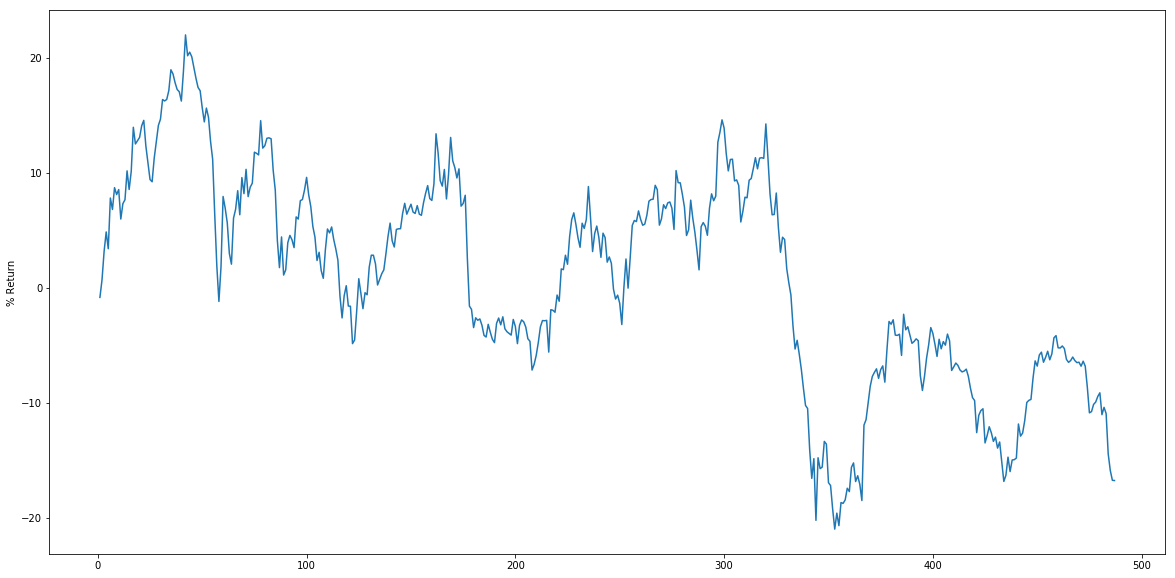

In [13]:
print('Accuracy =',round(classifier.score(test_data,test_labels)*100,2),'%')

godrej['Return'] = ((1 + godrej['Close Price'].pct_change()).cumprod() - 1) * 100

fig,ax = plt.subplots(figsize=(20,10))
plt.plot(godrej.index,godrej.Return)
plt.ylabel('% Return')
plt.show()